In [1]:
%matplotlib inline

##Initialize SVC

In [87]:
from nilearn.input_data import NiftiMasker
from sklearn.cross_validation import StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

In [4]:
k = 500
feature_selection = SelectKBest(f_classif, k=k)
svc = SVC()
anova_svc = Pipeline([('anova', feature_selection), ('svc', svc)])

In [5]:
anova_svc

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7fa5b4958de8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

##Load Mask

In [6]:
import epi_prediction
white_matter = epi_prediction.SimpleMasker('masks/white.nii')

In [6]:
white_matter

<epi_prediction.SimpleMasker instance at 0x7f6952fe7830>

In [7]:
import matplotlib.pyplot as plt
from nilearn.plotting import plot_img

/home/lbuser/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1256: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


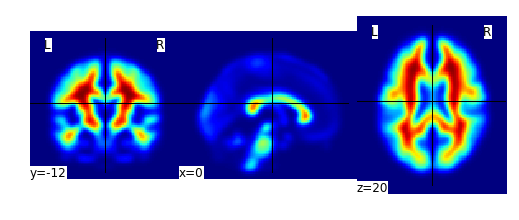

In [8]:
plot_img(white_matter._mask_image)
plt.show()

##Import Data

In [5]:
import epi_prediction
src_dir = '/home/lbuser/data/chuyu/process_normalize/'
control_filter = lambda file_name: 'CON' in file_name
patient_filter = lambda file_name: 'PAT' in file_name

In [6]:
epi_paths = epi_prediction.get_epi_paths(src_dir, patient_filter, control_filter)


In [7]:
mod_paths = epi_paths['kmean']

In [10]:
mod_paths

cons    [/home/lbuser/data/chuyu/process_normalize/kme...
pats    [/home/lbuser/data/chuyu/process_normalize/kme...
Name: kmean, dtype: object

In [13]:
mat = white_matter.transform_many(mod_paths['pats'] + mod_paths['cons'], verbose=True)

--------------------------------------------------------------------
####################################################################

In [14]:
mat.shape

(68, 302567)

In [16]:
labels = len(mod_paths['pats']) * [1] + len(mod_paths['cons']) * [0]

In [17]:
len(labels)

68

##Grid Search for Best Parameters of Gamma and C

In [18]:
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(svc__gamma=gamma_range, svc__C=C_range)
n_folds = np.floor_divide(32, 5)

cv = StratifiedKFold(labels, n_folds=n_folds)

In [19]:
total_runs = len(C_range) * len(gamma_range) * n_folds

scorer = epi_prediction.verbose_scorer(total_runs)
grid = GridSearchCV(anova_svc, param_grid=param_grid, cv=cv, scoring = scorer)

grid.fit(mat, labels)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

/home/lbuser/anaconda/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f69543f4410>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'svc__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])},
      

In [20]:
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
scores

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.67805789,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.72083864,  0.68238053,  0.65146945,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.70746965,  0.66090103,  0.64025599,  0.63709036,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.70746965,  0.68606443,  0.65386052,  0.59801742,  0.63709036,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

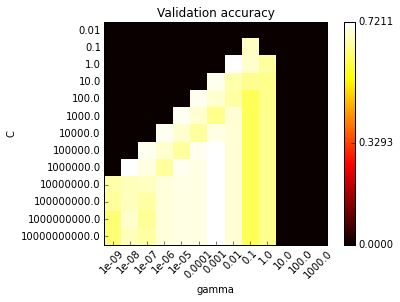

In [21]:
cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.hot)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.xlabel('gamma')
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel('C')
plt.title('Validation accuracy')

cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])

plt.show()

In [22]:
scores.shape

(13, 13)

In [23]:
np.max(scores)

0.72114731673555199

##Try With Thresholded White Matter Mask

In [1]:
import epi_prediction

In [94]:
white_matter = epi_prediction.SimpleMasker('masks/white.nii', threshold=.2)

In [95]:
mat = white_matter.transform_many(mod_paths['pats'] + mod_paths['cons'], verbose=True)

--------------------------------------------------------------------
####################################################################

In [96]:
labels = len(mod_paths['pats']) * [1] + len(mod_paths['cons']) * [0]

In [109]:
from sklearn.grid_search import GridSearchCV

C_range = np.logspace(-2, 10, 13)
gamma_range = np.logspace(-9, 3, 13)
param_grid = dict(svc__gamma=gamma_range, svc__C=C_range)
n_folds = np.floor_divide(32, 5)

cv = StratifiedKFold(labels, n_folds=n_folds)

In [113]:
total_runs = len(C_range) * len(gamma_range) * n_folds
anova_svc.set_params(svc__kernel='rbf')

scorer = epi_prediction.verbose_scorer(total_runs)
grid = GridSearchCV(anova_svc, param_grid=param_grid, cv=cv, scoring = scorer)

grid.fit(mat, labels)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f376d13ade8>)), ('svc', SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=1e-08, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__gamma': array([  1.00000e-09,   1.00000e-08,   1.00000e-07,   1.00000e-06,
         1.00000e-05,   1.00000e-04,   1.00000e-03,   1.00000e-02,
         1.00000e-01,   1.00000e+00,   1.00000e+01,   1.00000e+02,
         1.00000e+03]), 'svc__C': array([  1.00000e-02,   1.00000e-01,   1.00000e+00,   1.00000e+01,
         1.00000e+02,   1.00000e+03,   1.00000e+04,   1.00000e+05,
         1.00000e+06,   1.00000e+07,   1.00000e+08,   1.00000e+09,
         1.00000e+10])}

In [114]:
scores = [x[1] for x in grid.grid_scores_]
scores = np.array(scores).reshape(len(C_range), len(gamma_range))
scores

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.68630952,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.68630952,  0.69047619,  0.70980392,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.68630952,  0.67282913,  0.7323975 ,  0.71868573,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.68630952,  0.67282913,  0.70138146,  0.71902852,  0.71868573,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

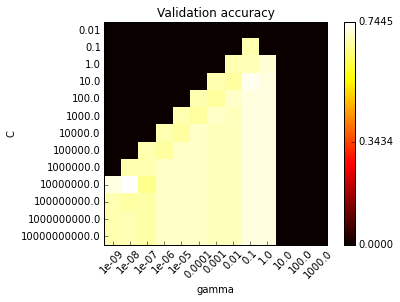

In [115]:
cax = plt.imshow(scores, interpolation="nearest", cmap=plt.cm.hot)
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.xlabel('gamma')
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel('C')
plt.title('Validation accuracy')

cbar = plt.colorbar(cax, ticks=[np.min(scores), np.mean(scores), np.max(scores)])

plt.show()

##Calculate Confusion Matrix

In [119]:
C = C_range[9]
gamma = gamma_range[1]
scores[9][1]

0.74449643493761142

In [120]:
anova_svc.set_params(svc__C=C, svc__gamma=gamma)

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f376d13ade8>)), ('svc', SVC(C=10000000.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
  gamma=1e-08, kernel='rbf', max_iter=-1, probability=False,
  random_state=None, shrinking=True, tol=0.001, verbose=False))])

In [121]:
cv = StratifiedKFold(labels, n_folds=n_folds)

labels_arr = np.array(labels)

cv_info, cv_info_train = epi_prediction.verbose_cv(mat, labels_arr, anova_svc, n_folds=6, verbose=False)

####
####
####
####
####
####


In [122]:
cv_info.confusion_matrix()

array([[31,  5],
       [10, 22]])

In [123]:
cv_info.normalized_confusion_matrix()

array([[ 0.86111111,  0.13888889],
       [ 0.3125    ,  0.6875    ]])

##Leave 1 Out Cross Validation

In [124]:
cv = StratifiedKFold(labels, n_folds=n_folds)

labels_arr = np.array(labels)

cv_info_1_out, cv_info_train_1_out = epi_prediction.verbose_cv(mat, 
                                                   labels_arr, 
                                                   anova_svc,
                                                   n_folds=31,
                                                   verbose=False)

####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####
####


In [125]:
cv_info_1_out.confusion_matrix()

array([[32,  4],
       [11, 21]])

In [126]:
cv_info_1_out.normalized_confusion_matrix()

array([[ 0.88888889,  0.11111111],
       [ 0.34375   ,  0.65625   ]])

In [127]:
cv_info_1_out.avg_f1_score()

0.62365591397849462

In [128]:
cv_info.avg_f1_score()

0.74318181818181817

In [129]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, [0, 1])
    plt.yticks(tick_marks, [0, 1])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

##Confusion Matrix For 6 Fold

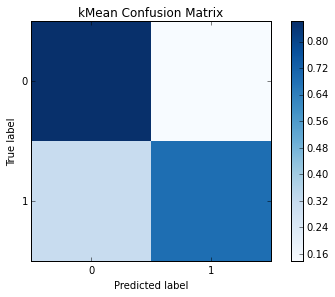

In [130]:
plot_confusion_matrix(cv_info.normalized_confusion_matrix(), 
                      title="kMean Confusion Matrix")

##Retrieve the Voxels

__Retrieving Important Voxels Requires Linear Classifier__

In [153]:
svc = SVC()
anova_svc_lin = Pipeline( [('anova', SelectKBest(k=500)), ('svc', svc)] )
anova_svc_lin.set_params(svc__kernel='linear')

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f376d13ade8>)), ('svc', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [175]:
C_range_lin = np.logspace(-3, 3, 7)

total_runs = len(C_range_lin) * n_folds

scorer = epi_prediction.verbose_scorer(total_runs)
grid_lin = GridSearchCV(anova_svc_lin, param_grid={"svc__C": C_range_lin}, cv=cv, scoring = scorer)

grid_lin.fit(mat, labels_arr)

------------------------------------------
##########################################

GridSearchCV(cv=sklearn.cross_validation.StratifiedKFold(labels=[1 1 ..., 0 0], n_folds=6, shuffle=False, random_state=None),
       estimator=Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f376d13ade8>)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'svc__C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring=make_scorer(verbose_score_fn), verbose=0)

In [176]:
grid_lin.grid_scores_

[mean: 0.00000, std: 0.00000, params: {'svc__C': 0.001},
 mean: 0.68631, std: 0.07227, params: {'svc__C': 0.01},
 mean: 0.68631, std: 0.07227, params: {'svc__C': 0.10000000000000001},
 mean: 0.70138, std: 0.10858, params: {'svc__C': 1.0},
 mean: 0.70138, std: 0.10858, params: {'svc__C': 10.0},
 mean: 0.70138, std: 0.10858, params: {'svc__C': 100.0},
 mean: 0.70138, std: 0.10858, params: {'svc__C': 1000.0}]

In [177]:
anova_svc_lin.set_params(svc__C=1)

Pipeline(steps=[('anova', SelectKBest(k=500, score_func=<function f_classif at 0x7f376d13ade8>)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

In [182]:
svc = anova_svc_lin.named_steps['svc']
anova = anova_svc_lin.named_steps['anova']

In [190]:
coeffs = np.zeros(white_matter._mask_image.shape)
for train, test in cv:
    expected = labels_arr[test]
    anova_svc_lin.fit(mat[train], labels_arr[train])
    coeffs = coeffs + np.abs(white_matter.inv_transform(anova.inverse_transform(svc.coef_)))

In [191]:
coeffs.shape

(91, 109, 91)

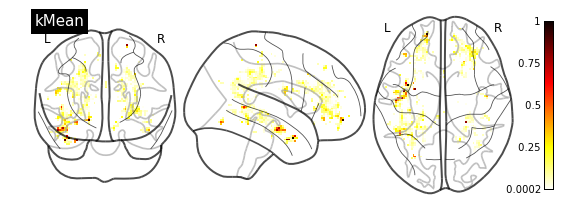

In [208]:
from nilearn.plotting import plot_glass_brain
coeffs_normalized = coeffs/np.max(coeffs)
plot_glass_brain(nib.Nifti1Image(coeffs_normalized, 
                                 affine = white_matter._mask_image.get_affine()), 
                 title="kMean",
                 colorbar=True)

##Generate Linear Confusion Matrix

In [211]:
labels_arr = np.array(labels)

cv_info_lin, cv_info_train_lin = epi_prediction.verbose_cv(mat, labels_arr, anova_svc_lin, n_folds=6, verbose=False)

####
####
####
####
####
####


In [212]:
cv_info_lin.confusion_matrix()

array([[28,  8],
       [10, 22]])

In [213]:
cv_info_lin.normalized_confusion_matrix()

array([[ 0.77777778,  0.22222222],
       [ 0.3125    ,  0.6875    ]])

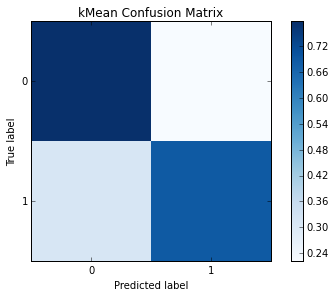

In [215]:
epi_prediction.plot_confusion_matrix(cv_info_lin.normalized_confusion_matrix(), "kMean Confusion Matrix")

In [216]:
cv_info_lin.avg_f1_score()

0.69898989898989905

In [221]:
cv_info.avg_f1_score()

0.74318181818181817